<a href="https://colab.research.google.com/github/phuonggtrann/DS-Unit-1-Sprint-2-Statistics/blob/master/module3/LS_DS_123_Introduction_to_Bayesian_Inference_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science Module 123

## Introduction to Bayesian Inference




## Assignment - Code it up!

We used pure math to apply Bayes Theorem to drug tests. Now write Python code to reproduce the results! This is purposefully open ended - you'll have to think about how you should represent probabilities and events. You can and should look things up.

Specific goals/targets:

### 1) Write a function 

`def prob_drunk_given_positive(prob_drunk_prior, false_positive_rate, true_positive_rate):` 

You should only truly need these two values in order to apply Bayes Theorem. In this example, imagine that individuals are taking a breathalyzer test with an **8% false positive rate**, a **100% true positive rate**, and that our prior belief about **drunk driving in the population is 1/1000**. 
 - What is the probability that a person is drunk after one positive breathalyzer test?
 - What is the probability that a person is drunk after two positive breathalyzer tests?
 - How many positive breathalyzer tests are needed in order to have a probability that's greater than 95% that a person is drunk beyond the legal limit?


First, I translate it to format

$$P(Drunk|+ test) = \frac{P(+ test|Drunk)P(Drunk( in-prior-belief))}{P(+ test)}$$

$$P(Drunk|+ test) = \frac{P(+ test|Drunk)P(Drunk( in-prior-belief))}{P(+ test|Drunk)P(Drunk)+P(+test|NotDrunk)P(NotDrunk)}$$


P(+ test|Drunk) = true positive rate ** 1 **

p(- test|Drunk) = false positive rate ** 0.08 **

P(Drunk(in−general−populace)) =  prior belief abt drunk driving in the population ** 1/1000 = 0.0001 ** (This is prob_drunk_prior)

In [0]:
def prob_drunk_given_positive(prob_drunk_prior,false_positive_rate):
  true_positive_rate = 1

  # numerator = true_positive * drunk-in-prior-belief
  numerator = true_positive_rate * prob_drunk_prior

  # Denominator 1: true_pos_rate * p(drunk)
  dem1 = true_positive_rate * prob_drunk_prior

  # Denomicator 2: false_pos_rate * p(notdrunk)
  dem2 = false_positive_rate * (1-prob_drunk_prior)

  # Calulated denominator
  dem = dem1 + dem2

  # Compute p(drunk | pos test)
  p_drunk_given_pos = numerator / dem

  return p_drunk_given_pos

In [5]:
# What is the probability that a person is drunk after one positive breathalyzer test?
# Initial prob_drunk_prior = 1/1000 = 0/0001
prob1 = prob_drunk_given_positive(1/1000, 0.08)
prob1

0.012357884330202669

In [6]:
# What is the probability that a person is drunk after two positive breathalyzer tests?
prob2 = prob_drunk_given_positive(prob1, 0.08)
prob2 

0.13525210993291495

In [8]:
# How many positive breathalyzer tests are needed in order to have a probability that's greater than 95% that a person is drunk beyond the legal limit?

# Initial / first test
prob = prob_drunk_given_positive(1/1000, 0.08)
num_of_test = 1

# use loop
while prob < 0.95: 
  prob = prob_drunk_given_positive(prob, 0.08)
  num_of_test += 1

num_of_test # This is what the question is asking for

4


### 2) Explore `scipy.stats.bayes_mvs`  
Read its documentation, and experiment with it on data you've tested in other ways earlier this week.
 - Create a visualization comparing the results of a Bayesian approach to a traditional/frequentist approach. (with a large sample size they should look close to identical, however, take this opportunity to practice visualizing condfidence intervals in general. The following are some potential ways that you could visualize confidence intervals on your graph:
  - [Matplotlib Error Bars](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.errorbar.html)
  - [Seaborn barplot with error bars](https://seaborn.pydata.org/generated/seaborn.barplot.html)
  - [Vertical ines to show bounds of confidence interval](https://www.simplypsychology.org/confidence-interval.jpg)
  - [Confidence Intervals on Box Plots](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.boxplot.html)

In [0]:
# import statements
import pandas as pd
import numpy as np 
from scipy import stats
import math
import matplotlib.pyplot as plt

In [11]:
# 1. Load and clean data / copy from mod 2
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data
column_headers = ['party','handicapped-infants','water-project',
                  'budget','physician-fee-freeze', 'el-salvador-aid',
                  'religious-groups','anti-satellite-ban',
                  'aid-to-contras','mx-missile','immigration',
                  'synfuels', 'education', 'right-to-sue','crime','duty-free',
                  'south-africa']

df = pd.read_csv('house-votes-84.data', names=column_headers)

# modifying value
df = df.replace({"y": 1, "n": 0, "?": np.NaN})
df = df.dropna()

# splitting
rep = df[df['party'] == 'republican']
dem = df[df['party'] == 'democrat']

--2020-05-13 20:38:54--  https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18171 (18K) [application/x-httpd-php]
Saving to: ‘house-votes-84.data’

house-votes-84.data 100%[===================>]  17.75K  --.-KB/s    in 0.1s    

2020-05-13 20:38:55 (135 KB/s) - ‘house-votes-84.data’ saved [18171/18171]



In [0]:
def confidence_interval(data, confidence=0.95):
  x_bar = data.mean() # this is mean
  n = len(data)
  s = data.std()
  std_err = s / math.sqrt(n)
  t = stats.t.ppf((1 + confidence) / 2.0, n - 1)
  margin_of_error = t*std_err
  lower_bound = x_bar - margin_of_error
  upper_bound = x_bar + margin_of_error
  return (lower_bound, x_bar, upper_bound)


lower, mean, upper = confidence_interval(rep['aid-to-contras'])

In [21]:
bayes_mean = stats.bayes_mvs(rep['aid-to-contras'])[0]
bayes_mean

Mean(statistic=0.14814814814814814, minmax=(0.09116557527832221, 0.20513072101797405))

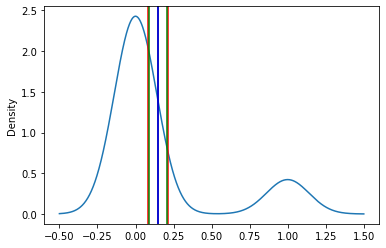

In [23]:
rep['aid-to-contras'].plot.density() # Bell curve plot for each issue 

# Traditional method
plt.axvline(x=lower, color='red', label = 'Traditional CI')
plt.axvline(x=mean, color='black', label='Traditional Mean')
plt.axvline(x=upper, color='red', label = 'Traditional CI')

# bayes method
plt.axvline(x=bayes_mean.statistic, color='blue', label = 'Baye Mean')
plt.axvline(x=bayes_mean.minmax[0], color='green', label = 'Baye CI')
plt.axvline(x=bayes_mean.minmax[1], color='green', label = 'Baye CI')

plt.show()

### 3) In your own words, summarize the difference between Bayesian and Frequentist statistics

If you're unsure where to start, check out [this blog post of Bayes theorem with Python](https://dataconomy.com/2015/02/introduction-to-bayes-theorem-with-python/).

**Frequentist statitistics** relies on fixed parameters and varying data to determine whether or not an event occured.

**Bayseian Statistics** take into consideration prior knowledge of probability to determine the likelihood an event has occured. Data is fixed and parameters vary.  

## Resources

- [Worked example of Bayes rule calculation](https://en.wikipedia.org/wiki/Bayes'_theorem#Examples) (helpful as it fully breaks out the denominator)
- [Source code for mvsdist in scipy](https://github.com/scipy/scipy/blob/90534919e139d2a81c24bf08341734ff41a3db12/scipy/stats/morestats.py#L139)

## Stretch Goals:

- Go back and study the content from Modules 1 & 2 to make sure that you're really comfortable with them.
- Apply a Bayesian technique to a problem you previously worked (in an assignment or project work) on from a frequentist (standard) perspective
- Check out [PyMC3](https://docs.pymc.io/) (note this goes beyond hypothesis tests into modeling) - read the guides and work through some examples
- Take PyMC3 further - see if you can build something with it!